We illustrate the usage of `gp6` for the reconstruction of a cosmological function.

In [1]:
import os, sys
import numpy as np
import matplotlib.pyplot as plt
from numpy.linalg import inv, det

from math import factorial # for Savitzky-Golay smoothing of DE EoS

from gp6.gp6 import *
from scipy.optimize import minimize
from scipy.linalg import block_diag
from numpy.random import multivariate_normal as MN

As a test bed, we consider the cosmic chronometers (CC) data with its full covariance matrix.

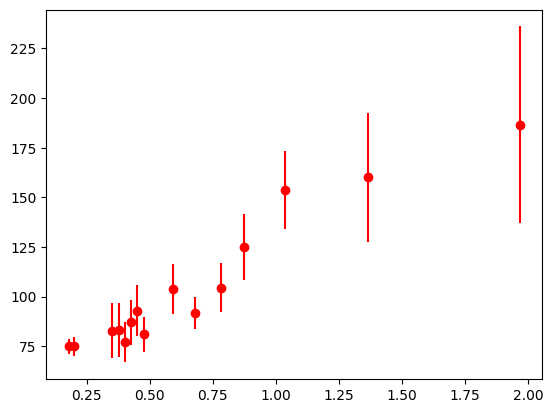

In [2]:
# import the data points
filename = 'https://gitlab.com/mmoresco/CCcovariance/-/raw/master/data/HzTable_MM_BC03.dat'
z_cc, Hz_cc, errHz_cc = np.genfromtxt(filename, comments = '#', usecols = (0,1,2), \
                                      unpack = True, delimiter = ',')
ref = np.genfromtxt(filename, comments = '#', usecols = (3), unpack = True, \
                    dtype = str, delimiter = ',')

fig, ax = plt.subplots()
ax.errorbar(z_cc, Hz_cc, yerr = errHz_cc, fmt = 'o', color = 'red')
plt.show()

# estimate covariance matrix
# import CC covariance matrix data
filename = 'https://gitlab.com/mmoresco/CCcovariance/-/raw/master/data/data_MM20.dat'
zmod, imf, slib, sps, spsooo = np.genfromtxt(filename, comments = '#', \
                                             usecols = (0,1,2,3,4), unpack = True)

# calculating CC covariance matrix
cov_mat_diag = np.zeros((len(z_cc), len(z_cc)), dtype = 'float64') 

for i in range(len(z_cc)):
    cov_mat_diag[i,i] = errHz_cc[i]**2

imf_intp = np.interp(z_cc, zmod, imf)/100
slib_intp = np.interp(z_cc, zmod, slib)/100
sps_intp = np.interp(z_cc, zmod, sps)/100
spsooo_intp = np.interp(z_cc, zmod, spsooo)/100

cov_mat_imf = np.zeros((len(z_cc), len(z_cc)), dtype = 'float64')
cov_mat_slib = np.zeros((len(z_cc), len(z_cc)), dtype = 'float64')
cov_mat_sps = np.zeros((len(z_cc), len(z_cc)), dtype = 'float64')
cov_mat_spsooo = np.zeros((len(z_cc), len(z_cc)), dtype = 'float64')

for i in range(len(z_cc)):
    for j in range(len(z_cc)):
        cov_mat_imf[i,j] = Hz_cc[i] * imf_intp[i] * Hz_cc[j] * imf_intp[j]
        cov_mat_slib[i,j] = Hz_cc[i] * slib_intp[i] * Hz_cc[j] * slib_intp[j]
        cov_mat_sps[i,j] = Hz_cc[i] * sps_intp[i] * Hz_cc[j] * sps_intp[j]
        cov_mat_spsooo[i,j] = Hz_cc[i] * spsooo_intp[i] * Hz_cc[j] * spsooo_intp[j]

cov_cc = cov_mat_spsooo + cov_mat_imf + cov_mat_diag
inv_cov_mat = inv(cov_cc)

(sign, logdet) = np.linalg.slogdet(cov_cc)
determinant = np.exp(logdet)

For simplicity, we create a class to use GP with the CC data, provided a set of hyperparameters (length and height). We demonstrate this for an arbitrary GP with a random choice of the hyperparameters. 

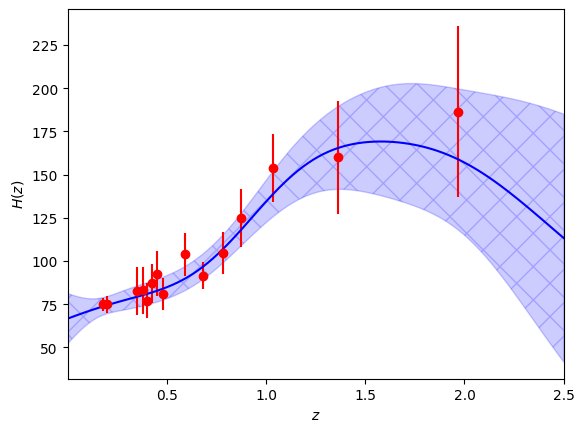

In [3]:
# Zs = np.logspace(np.log10(1e-3), np.log10(2.5), 100) # logspace reconstruction
Zs = np.linspace(1e-5, 2.5, 100)

# example with the Cauchy kernel
rec_CC = GP(kern = 'chy', l = 1, A = 100).predict(z_cc, Hz_cc, cov_cc, Zs)

# this example
fig, ax = plt.subplots()
ax.errorbar(z_cc, Hz_cc, yerr = errHz_cc, fmt = 'o', color = 'red')
ax.plot(rec_CC['z'], rec_CC['Y'], 'b-')
ax.fill_between(rec_CC['z'], \
                rec_CC['Y'] - np.sqrt(rec_CC['varY']), \
                rec_CC['Y'] + np.sqrt(rec_CC['varY']), \
                alpha = 0.2, color = 'blue', edgecolor = 'blue', \
                hatch = 'x')
ax.set_xlim(min(Zs), max(Zs))
ax.set_xlabel('$z$')
ax.set_ylabel('$H(z)$')
plt.show()

At this point, we proceed to optimize the hyperparameters of the GP for a given kernel. We focus on the Cauchy kernel for the remainder of this notebook for demonstration purposes.

In [4]:
def llike_GPcc(x):
    '''returns negative of GP log marginal likelihood'''
    lml = GP(kern = 'chy', l = x[0], A = x[1]).get_logmlike(z_cc, Hz_cc, cov_cc)
    return -lml

mnmz_GPcc = minimize(llike_GPcc, [max(z_cc) - min(z_cc), 0.5*(max(Hz_cc) + min(Hz_cc))], \
                     method = 'Nelder-Mead', tol = 1e-7)
print(mnmz_GPcc)

 final_simplex: (array([[  2.73986095, 127.58365503],
       [  2.73986094, 127.58365509],
       [  2.73986094, 127.58365494]]), array([62.3784394, 62.3784394, 62.3784394]))
           fun: 62.37843940221444
       message: 'Optimization terminated successfully.'
          nfev: 137
           nit: 68
        status: 0
       success: True
             x: array([  2.73986095, 127.58365503])


Above we can see that the optimization was performed manually using the log-marginal likelihood (`get_logmlike`) method in gp6. This allows us to also consider other ways to optimize GP, say, by using the more rigorous albeit time consuming sampling over the hyperparameters.

But of course, for convenience, gp6 also has a built-in method `optimize` which utilizes often-sufficient optimization for GP reconstruction purposes.

In [5]:
gp6_cc = GP('chy', l = 1, A = 100) # arbitrary hyperparameter choice
gp6_cc.optimize(z_cc, Hz_cc, cov_cc) # this also returns a dictionary of the optimal hyperparameters

print()
print('Hyperparameters now set to the optimized GP')
print(gp6_cc.length, gp6_cc.height)


Hyperparameters now set to the optimized GP
2.739860947521544 127.5836550349394


The reconstructed Hubble function and its derivative $H'(z)$ look like the following.

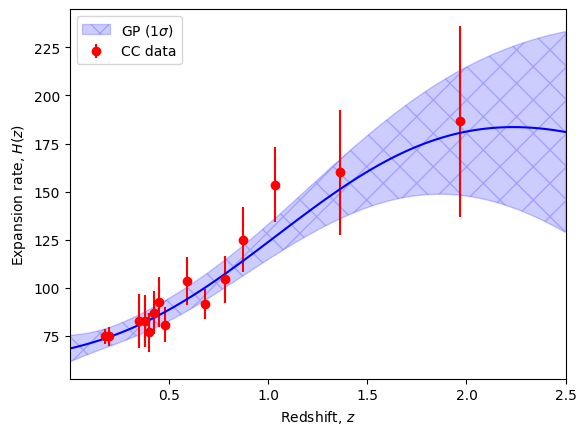

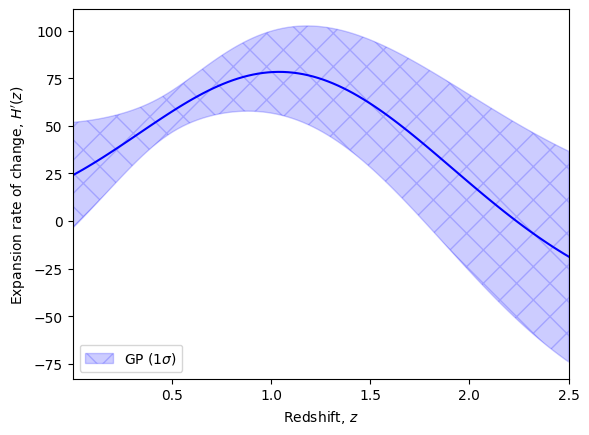

In [6]:
gp6_cc = GP('chy', l = 1, A = 100)
gp6_cc.optimize(z_cc, Hz_cc, cov_cc) # sets hyperparameters to optimal values given CC data

# reconstructed H(z)
Hz_rec = gp6_cc.predict(z_cc, Hz_cc, cov_cc, Zs)
fig, ax = plt.subplots()
ax.errorbar(z_cc, Hz_cc, yerr = errHz_cc, fmt = 'o', color = 'red', \
            label = 'CC data')
ax.plot(Hz_rec['z'], Hz_rec['Y'], 'b-')
ax.fill_between(Hz_rec['z'], \
                Hz_rec['Y'] - np.sqrt(Hz_rec['varY']), \
                Hz_rec['Y'] + np.sqrt(Hz_rec['varY']), \
                alpha = 0.2, color = 'blue', edgecolor = 'blue', \
                hatch = 'x', label = r'GP ($1\sigma$)')
ax.set_xlim(min(Zs), max(Zs))
ax.set_xlabel('Redshift, $z$')
ax.set_ylabel('Expansion rate, $H(z)$')
ax.legend(loc = 'upper left')
plt.show()

# first derivative of H(z)
dHdz_rec = gp6_cc.predict_d1F(z_cc, Hz_cc, cov_cc, Zs, with_covYdY = True)
fig, ax = plt.subplots()
ax.plot(dHdz_rec['z'], dHdz_rec['Y'], 'b-')
ax.fill_between(dHdz_rec['z'], \
                dHdz_rec['Y'] - np.sqrt(dHdz_rec['varY']), \
                dHdz_rec['Y'] + np.sqrt(dHdz_rec['varY']), \
                alpha = 0.2, color = 'blue', edgecolor = 'blue', \
                hatch = 'x', label = r'GP ($1\sigma$)')
ax.set_xlim(min(Zs), max(Zs))
ax.set_xlabel('Redshift, $z$')
ax.set_ylabel('Expansion rate of change, $H^\prime(z)$')
ax.legend(loc = 'lower left')
plt.show()

We note that the GP also produces the covariance between $H(z)$ and its derivative. This is important for reconstructing functions of the GP and its derivative. We showcase this by obtaining the dark energy equation of state as follows.

In [7]:
# GP results (optimized)
z = Hz_rec['z']
Hz = Hz_rec['Y']
errHz = np.sqrt(Hz_rec['varY'])
dHdz = dHdz_rec['Y']
errdHdz = np.sqrt(dHdz_rec['varY'])
cov_Hz_dHdz = dHdz_rec['covYdY']

H0 = Hz[0]
errH0 = errHz[0]

Om0, errOm0 = 0.3153, 0.0073 # Planck 2018 best fit

# mean and cov of parameters
ave_params = [np.array([Hz[i], dHdz[i], H0, Om0]) for i in np.arange(0, len(Hz))]
cov_params = [block_diag(C, errH0**2, errOm0**2) for C in cov_Hz_dHdz]

# reconstruct Quintessence potential and DE EoS using MC error propagation
Vz = np.zeros((len(z), 2))
ArcTanEoSz = np.zeros((len(z), 3))

n_s = 10000 # MC sampling size at each redshift
for i in np.arange(0, len(z)):
    V_samples = np.zeros(n_s)
    ArcTanEoS_samples = np.zeros(n_s)
    for j in np.arange(0, n_s): # jth draw
        Hz_j, dHdz_j, H0_j, Om0_j = MN(ave_params[i], cov_params[i])
        V_j = -(3/2)*(H0_j**2)*Om0_j*((1 + z[i])**3) \
              + Hz_j*(3*Hz_j - dHdz_j*(1 + z[i]))

        phip2_j = -3*(H0_j**2)*Om0_j*(1 + z[i])/(Hz_j**2) \
                  + 2*dHdz_j/(Hz_j*(1 + z[i]))

        K_j = (1/2)*((Hz_j*(1 + z[i]))**2)*phip2_j
        w_de_j = (K_j - V_j)/(K_j + V_j)

        V_samples[j] = V_j
        ArcTanEoS_samples[j] = np.arctan(1 + w_de_j)

    Vz[i][0] = np.mean(V_samples)
    Vz[i][1] = np.std(V_samples)

    ArcTanEoSz[i][0] = np.percentile(ArcTanEoS_samples, 50) # median
    ArcTanEoSz[i][1] = np.percentile(ArcTanEoS_samples, 50 - 34.1) # 68.2% probability mass
    ArcTanEoSz[i][2] = np.percentile(ArcTanEoS_samples, 50 + 34.1)

So here are the results (smoothened *a la* [Savitzky-Golay](https://scipy.github.io/old-wiki/pages/Cookbook/SavitzkyGolay) and improved by GPT-3 for python 3).

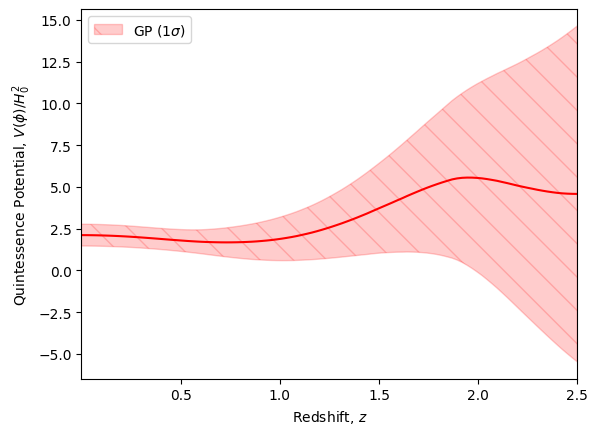

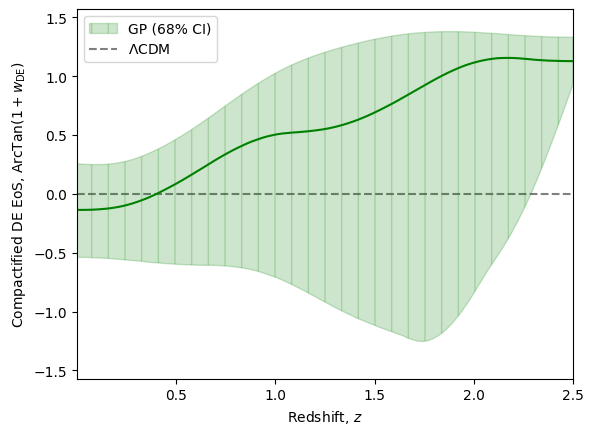

In [8]:
# here are the plots
# the reconstructed quintessence potential
fig, ax = plt.subplots()
VzQ = savitzky_golay(Vz[:, 0])
errVzQ = savitzky_golay(Vz[:, 1])
ax.plot(z, VzQ/(H0**2), 'r-')
ax.fill_between(z,
                (VzQ - errVzQ)/(H0**2), \
                (VzQ + errVzQ)/(H0**2), \
                alpha = .2, facecolor = 'red', \
                edgecolor = 'red', hatch = '\\', label = 'GP ($1\sigma$)')
ax.set_xlabel('Redshift, $z$')
ax.set_ylabel('Quintessence Potential, $V(\phi)/H_0^2$')
ax.set_xlim(min(z), max(z))
ax.legend(loc = 'upper left')
plt.show()

# the reconstructed DE EoS (compactified)
fix, ax = plt.subplots()
AwDE = savitzky_golay(ArcTanEoSz[:, 0])
AwDE_upper = savitzky_golay(ArcTanEoSz[:, 1])
AwDE_lower = savitzky_golay(ArcTanEoSz[:, 2])
ax.plot(z, AwDE, 'g-')
ax.fill_between(z, AwDE_upper, AwDE_lower, \
                alpha = .2, facecolor = 'green', \
                edgecolor = 'green', hatch = '|', label = 'GP (68% CI)')
ax.plot(z, [0]*len(z), 'k--', zorder = 0, alpha = 0.5, label = r'$\Lambda$CDM')
ax.set_xlabel(r'Redshift, $z$')
ax.set_ylabel(r'Compactified DE EoS, ArcTan($1 + w_{\rm DE}$)')
ax.set_xlim(min(z), max(z))
ax.set_ylim(-np.pi/2, np.pi/2)
ax.legend(loc = 'upper left')
plt.show()

All of the above results can be done also for other kernels.

End of notebook